# Some questions

- Water LW looks visually good in SC compared to brain right? So why is the data so different?

- Find why MRS quality data varies from one subject to another (THIS IS CRITICAL)
-- Things to check:
    -- B0 (LW)
    -- B1 (Vref)
    -- BMI stuff (height/weight)
    -- unperfect breathing gating (check respiratory stability?)
    -- susceptiblity effects (check LW variation STD)
    -- lungs are closer to SC for small subjects (check voxel position, subject height)
- When doing this, normalize SNR per volume, NA, include NA rejected ? already done? voxel size, position ?

- SNR according to NA plot, normalized or not

- check for intra-subject repro if any data

- What does CRB errors depend on? scatter plots CRBS(met) = f(SNR, FWHM)
-- Use this to choose which metabolites to include, how many NA are really needed

- CRBs: relative / absolute? work according to the last quantification review!

- Percentage of acceptable or quantifiable MR spectra?

- About the >4.7ppm artefact, correlate with shimming voltages too

- What about heart and resp bpm?

In [3]:
# %% init
from IPython import get_ipython
get_ipython().magic("clear")
get_ipython().magic("matplotlib inline")

import os
os.chdir("/home/tangir/crmbm/python/shrimp")

import suspect
import numpy as np
import mrs.db as db
import mrs.reco as reco
import mrs.log as log
import matplotlib.pylab as plt

plt.close("all")
plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.max_open_warning'] = 1000
plt.rcParams["figure.figsize"] = [8, 6]
log.setLevel(log.DEBUG)

rdb = db.data_db("/home/tangir/crmbm/acq_db/20201023_brain_fit.pkl")
df = rdb.to_dataframe()

(DEBUG) Loaded backend module://ipykernel.pylab.backend_inline version unknown.
(DEBUG) data_db._read_db_file: reading db file [/home/tangir/crmbm/acq_db/20201023_brain_fit.pkl]...
(INFO)  data_db.to_dataframe: converting db into pandas dataframe...


## Select datasets

In [4]:
df

,patient,study,hash,dataset_legend,dataset_raw_files[0],dataset_raw_files[1],dataset_raw_data__dt,dataset_raw_data__f0,dataset_raw_data__te,dataset_raw_data__tr,dataset_raw_data_ppm0,dataset_raw_data_transform,dataset_raw_data_metadata_patient_name,dataset_raw_data_metadata_patient_id,dataset_raw_data_metadata_patient_birthdate,dataset_raw_data_metadata_exam_date,dataset_raw_data_metadata_exam_time,dataset_raw_data_voxel_dimensions,dataset_raw_data_data_ref__dt,dataset_raw_data_data_ref__f0,dataset_raw_data_data_ref__te,dataset_raw_data_data_ref__tr,dataset_raw_data_data_ref_ppm0,dataset_raw_data_data_ref_transform,dataset_raw_data_data_ref_metadata_patient_name,dataset_raw_data_data_ref_metadata_patient_id,dataset_raw_data_data_ref_metadata_patient_birthdate,dataset_raw_data_data_ref_metadata_exam_date,dataset_raw_data_data_ref_metadata_exam_time,dataset_raw_data_data_ref_voxel_dimensions,dataset_raw_data_data_ref_data_ref,dataset_raw_data_data_ref__display_label,dataset_raw_data_data_ref__display_offset,dataset_raw_data_data_ref__patient_name,dataset_raw_data_data_ref__patient_birthday,dataset_raw_data_data_ref__patient_sex,dataset_raw_data_data_ref__patient_weight,dataset_raw_data_data_ref__patient_height,dataset_raw_data_data_ref__physio_file,dataset_raw_data_data_ref__sequence_name,...,reco_pipeline_analyze_job_list[2]_display,reco_pipeline_analyze_job_list[2]_display_range_ppm[0],reco_pipeline_analyze_job_list[2]_display_range_ppm[1],reco_pipeline_analyze_job_list[3]_0_func,reco_pipeline_analyze_job_list[3]_0_name,reco_pipeline_analyze_job_list[3]_POI_shift_range_ppm[0],reco_pipeline_analyze_job_list[3]_POI_shift_range_ppm[1],reco_pipeline_analyze_job_list[3]_POI_shift_true_ppm,reco_pipeline_analyze_job_list[3]_display,reco_pipeline_analyze_job_list[3]_display_range_ppm[0],reco_pipeline_analyze_job_list[3]_display_range_ppm[1],reco_pipeline_analyze_enable,reco_pipeline_analyze_display,reco_pipeline__pipeline__isfrozen,fit_pipeline_easy_params_ref_area,fit_pipeline_easy_params_ref_area_pnorm,fit_pipeline_easy_params_area,fit_pipeline_easy_params_area_pnorm,fit_pipeline_easy_params_ref_fit,fit_pipeline_easy_params_fit_final,fit_pipeline_easy_optim_result,fit_pipeline_easy_fittool,fit_pipeline_medium_params_ref_area,fit_pipeline_medium_params_ref_area_pnorm,fit_pipeline_medium_params_area,fit_pipeline_medium_params_area_pnorm,fit_pipeline_medium_params_ref_fit,fit_pipeline_medium_params_fit_final,fit_pipeline_medium_optim_result,fit_pipeline_medium_fittool,fit_pipeline_hard_params_ref_area,fit_pipeline_hard_params_ref_area_pnorm,fit_pipeline_hard_params_area,fit_pipeline_hard_params_area_pnorm,fit_pipeline_hard_params_ref_fit,fit_pipeline_hard_params_fit_final,fit_pipeline_hard_optim_result,fit_pipeline_hard_fittool,timestamp,reco_pipeline_settings_datasets_indexes
0,296,1,16d71eb60d555d564285780e3a956a3b,#0 brain - sLASER R:N=5:5,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,0.0001,297.206367,21.96,3000.0,4.7,"[[-14.999921178265339, 0.005234976875915777, 0...",296_YM_P1_BRAINMOELLE,tr/296_YM_P1_BRAINMOELLE,19910702,xxxxxx,xxxxxx,"(10, 10, 10)",0.0001,297.206367,21.96,3000.0,4.7,"[[-14.999921178265339, 0.005234976875915777, 0...",296_YM_P1_BRAINMOELLE,tr/296_YM_P1_BRAINMOELLE,19910702,xxxxxx,xxxxxx,"(10, 10, 10)",None,#0 brain - sLASER R:N=5:5 [REF] [RAW],0.0,296_YM_P1_BRAINMOELLE,1991-07-02,F,65.0,1.80,None,eja_svs_slaser,...,True,1,6,<function MRSData2.correct_freqshift_1d at 0x7...,frequency shifting,4.5,5.2,4.7,True,1,6,True,True,True,"[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[[0.0, 5.0, -20.0, -0.1], [0.0, 5.0, -20.0, -0...","[[0.0, 5.5, 0.0, 0.0], [0.0, 5.5, 0.0, 0.0], [...","{'x': [22.62371927069643, 34.38217377544576, -...",<mrs.fit.fit_tool object at 0x7f080ebab3d0>,"[[0.0, 0.0, 0.0, 0.0], [0.0, 0.

## Check SNR and need for moving average during processing
Seems that some datasets with low SNR needed moving averaging for the frequency realignment and the data rejection to work. Could we maybe find a SNR threshold or a simple relation between SNR and moving average window size so that it is set automatically?

Text(0, 0.5, 'Moving average window (datarej)')

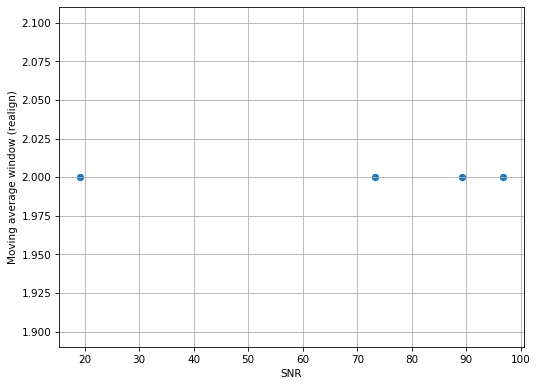

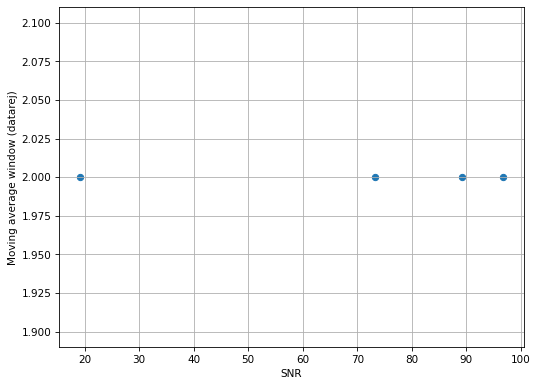

In [50]:
# extract SNR before realignment
snr_list = []
lw_list = []
na_realigning_list = []
na_datarej_list = []

for this_patient in rdb_sel:
    for this_study in rdb_sel[this_patient]:
        for this_scan in rdb_sel[this_patient][this_study]:
            (snr, lw) = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["zero-filling"].values()
            na_realigning = rdb_sel[this_patient][this_study][this_scan]["reco_pipeline"].job["realigning"]["moving_averages"]
            na_datarej = rdb_sel[this_patient][this_study][this_scan]["reco_pipeline"].job["data-rejecting"]["moving_averages"]
            snr_list.append(snr)
            lw_list.append(lw)
            na_realigning_list.append(na_realigning)
            na_datarej_list.append(na_datarej)

fig = plt.figure()
ax = fig.subplots()
ax.scatter(snr_list, na_realigning_list)
ax.grid('on')
ax.set_xlabel("SNR")
ax.set_ylabel("Moving average window (realign)")

fig = plt.figure()
ax = fig.subplots()
ax.scatter(snr_list, na_datarej_list)
ax.grid('on')
ax.set_xlabel("SNR")
ax.set_ylabel("Moving average window (datarej)")


## Group-averaged rejected spectrum
Average over all subjects the data rejected into one crappy spectrum

(DEBUG) MRSData2.correct_zerofill_nd: zero-filling [None]...
(DEBUG) MRSData2.correct_zerofill_nd: 16384-pts signal + 0 zeros = 16384-pts zero-filled signal...
(DEBUG) MRSData2.correct_zerofill_nd: zero-filling [None]...
(DEBUG) MRSData2.correct_zerofill_nd: 16384-pts signal + 0 zeros = 16384-pts zero-filled signal...
(DEBUG) MRSData2.correct_zerofill_nd: zero-filling [None]...
(DEBUG) MRSData2.correct_zerofill_nd: 16384-pts signal + 0 zeros = 16384-pts zero-filled signal...
(DEBUG) MRSData2.correct_zerofill_nd: zero-filling [None]...
(DEBUG) MRSData2.correct_zerofill_nd: 16384-pts signal + 0 zeros = 16384-pts zero-filled signal...


Text(0, 0.5, 'average rejected spectra (real part)')

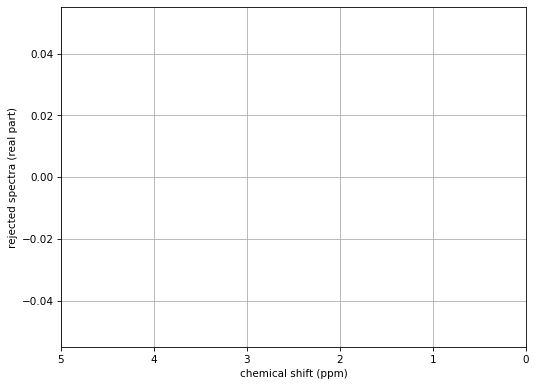

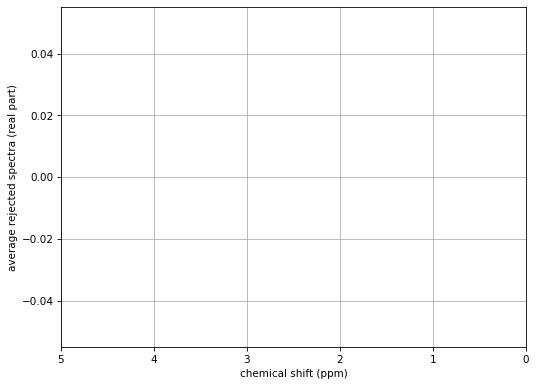

In [51]:
# extract rej spectrum for each dataset
s_arr = None
dt_final = 0.0001

fig = plt.figure()
ax = fig.subplots()

for this_patient in rdb_sel:
    for this_study in rdb_sel[this_patient]:
        for this_scan in rdb_sel[this_patient][this_study]:
            s = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["data"].data_rejection[0]["Rejected spectrum"]
            old_t = np.arange(0, s.shape[0] * s.dt, s.dt)
            new_t = np.arange(0, s.shape[0] * dt_final, dt_final) 
            
            s_interp = np.interp(new_t, old_t, s)
            
            # convert to suspect
            s_MRSData = suspect.MRSData(s_interp, dt_final, s.f0)
            s_MRSData2 = s_MRSData.view(reco.MRSData2)        
            
            s_MRSData2 = s_MRSData2.correct_zerofill_nd()
            if(s_arr is None):
                s_arr = s
            else:
                s_arr = np.vstack((s_arr, s_MRSData2))
                
            ax.plot(s_MRSData2.frequency_axis_ppm(), np.real(s_MRSData2.spectrum()))
            

ax.grid('on')
ax.set_xlim(5, 0)
ax.set_xlabel("chemical shift (ppm)")
ax.set_ylabel("rejected spectra (real part)")

# make the average + std plot
s_mean = np.mean(s_arr, axis=0)
s_mean = suspect.MRSData(s_mean, dt_final, s.f0)
s_mean = s_mean.view(reco.MRSData2)

s_std = np.std(s_arr, axis=0)
s_std = suspect.MRSData(s_std, dt_final, s.f0)
s_std = s_std.view(reco.MRSData2)

fig = plt.figure()
ax = fig.subplots()
ax.plot(s_mean.frequency_axis_ppm(), np.real(s_mean.spectrum()))
ax.grid('on')
ax.set_xlim(5, 0)
ax.set_xlabel("chemical shift (ppm)")
ax.set_ylabel("average rejected spectra (real part)")


## Frequency realignment, data rejection: performance in terms of SNR and LW
- Evaluate data rejection approach with peak properties estimated before and after :)

[Text(0, 0, 'Data rejection (1)'),
 Text(1, 0, 'Data rejection (2)'),
 Text(2, 0, 'Freq. realignment')]

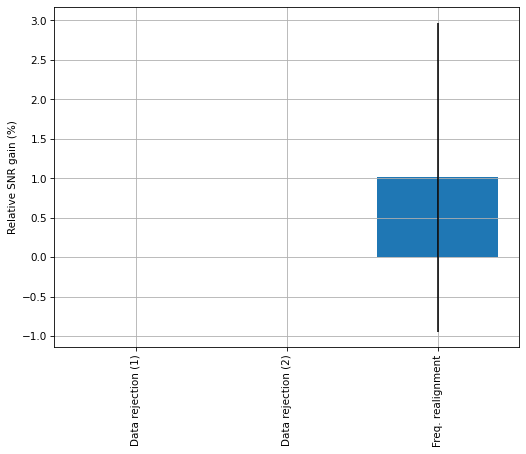

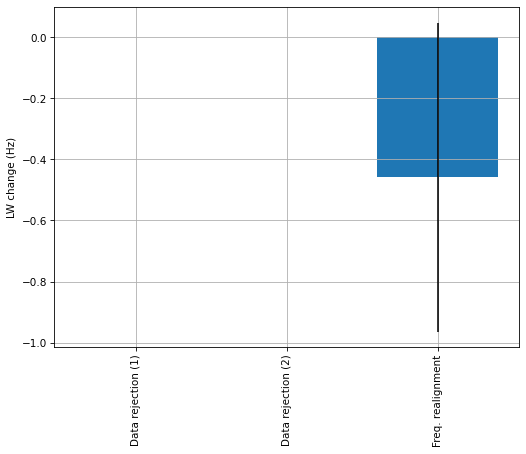

In [52]:
# extract SNR and LW estimatation regarding frequency realignment and data rejection 
snr_gain_datarej1_list = []
snr_gain_datarej2_list = []
lw_gain_datarej1_list = []
lw_gain_datarej2_list = []
# realign
snr_gain_realign_list = []
lw_gain_realign_list  = []

for this_patient in rdb_sel:
    for this_study in rdb_sel[this_patient]:
        for this_scan in rdb_sel[this_patient][this_study]:
            # data rejection
            snr_before_datarej1 = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["data"].data_rejection[0]["Pre-rejection"]["snr"]
            snr_before_datarej2 = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["frequency realigning"]["snr"]
            snr_after_datarej1 = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["data"].data_rejection[0]["Post-rejection"]["snr"]
            snr_after_datarej2 = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["data rejecting"]["snr"]
            #
            lw_before_datarej1 = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["data"].data_rejection[0]["Pre-rejection"]["lw"]
            lw_before_datarej2 = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["frequency realigning"]["lw"]
            lw_after_datarej1 = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["data"].data_rejection[0]["Post-rejection"]["lw"]
            lw_after_datarej2 = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["data rejecting"]["lw"]
            # realign
            snr_before_realign = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["apodizing"]["snr"]
            snr_after_realign = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["frequency realigning"]["snr"]
            #
            lw_before_realign = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["apodizing"]["lw"]
            lw_after_realign = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["frequency realigning"]["lw"]
            
            # SNR and LW gain calculation
            snr_gain_datarej1 = (snr_after_datarej1 - snr_before_datarej1) / snr_before_datarej1 * 100.0
            snr_gain_datarej2 = (snr_after_datarej2 - snr_before_datarej2) / snr_before_datarej2 * 100.0
            lw_gain_datarej1 = (lw_after_datarej1 - lw_before_datarej1)
            lw_gain_datarej2 = (lw_after_datarej2 - lw_before_datarej2)
            #
            snr_gain_realign = (snr_after_realign - snr_before_realign) / snr_before_realign * 100.0
            lw_gain_realign = (lw_after_realign - lw_before_realign)
            
            # store
            snr_gain_datarej1_list.append(snr_gain_datarej1)
            snr_gain_datarej2_list.append(snr_gain_datarej2)
            lw_gain_datarej1_list.append(lw_gain_datarej1)
            lw_gain_datarej2_list.append(lw_gain_datarej2)
            #
            snr_gain_realign_list.append(snr_gain_realign)
            lw_gain_realign_list.append(lw_gain_realign)
            
snr_gain_datarej1_mean = np.mean(snr_gain_datarej1_list)
snr_gain_datarej1_std = np.std(snr_gain_datarej1_list)
snr_gain_datarej2_mean = np.mean(snr_gain_datarej2_list)
snr_gain_datarej2_std = np.std(snr_gain_datarej2_list)
#
lw_gain_datarej1_mean = np.mean(lw_gain_datarej1_list)
lw_gain_datarej1_std = np.std(lw_gain_datarej1_list)
lw_gain_datarej2_mean = np.mean(lw_gain_datarej2_list)
lw_gain_datarej2_std = np.std(lw_gain_datarej2_list)

# realign
snr_gain_realign_mean = np.mean(snr_gain_realign_list)
snr_gain_realign_std = np.std(snr_gain_realign_list)
#
lw_gain_realign_mean = np.mean(lw_gain_realign_list)
lw_gain_realign_std = np.std(lw_gain_realign_list)

xlabels = ["Data rejection (1)", "Data rejection (2)", "Freq. realignment"]

fig = plt.figure()
ax = fig.subplots()
pos_bars = np.arange(3)
ax.bar(pos_bars, [snr_gain_datarej1_mean, 
                  snr_gain_datarej2_mean, 
                  snr_gain_realign_mean], 
       yerr=[snr_gain_datarej1_std, 
             snr_gain_datarej2_std, 
             snr_gain_realign_std])
ax.grid('on')
ax.set_ylabel("Relative SNR gain (%)")
ax.set_xticks(pos_bars)
ax.set_xticklabels(xlabels, rotation=90)       

fig = plt.figure()
ax = fig.subplots()
pos_bars = np.arange(3)
ax.bar(pos_bars, [lw_gain_datarej1_mean, 
                  lw_gain_datarej2_mean, 
                  lw_gain_realign_mean], 
       yerr=[lw_gain_datarej1_std, 
             lw_gain_datarej2_std, 
             lw_gain_realign_std])
ax.grid('on')
ax.set_ylabel("LW change (Hz)")
ax.set_xticks(pos_bars)
ax.set_xticklabels(xlabels, rotation=90)   
        

## Theoritical, effective (gating) and retro-effective acquisition duration
- Compare theory and effective acquisition durations

[Text(0, 0, 'Theory vs. effective'),
 Text(1, 0, 'Theory vs. theory retro'),
 Text(2, 0, 'Effective vs. effective retro')]

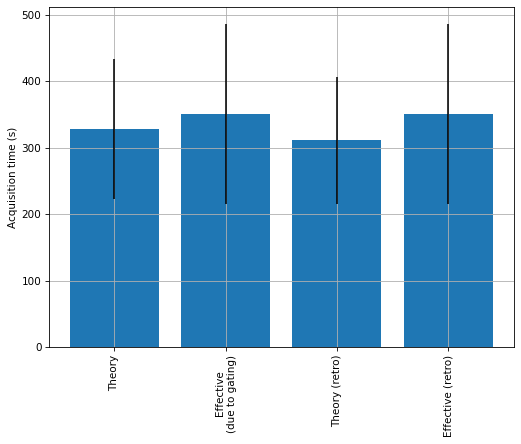

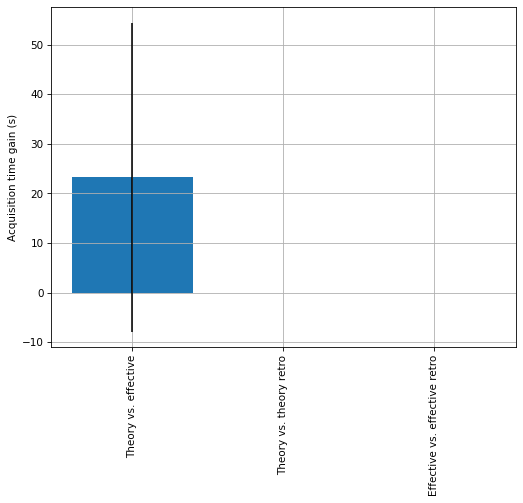

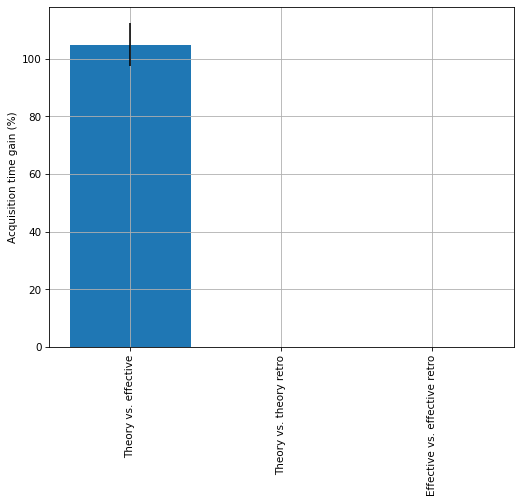

In [53]:
# extract na, ds, tr (=theory), effective and na after datarej
acq_dur_theory_list = []
acq_dur_eff_list = []
acq_dur_theory_retro_list = []
acq_dur_eff_retro_list = []

for this_patient in rdb_sel:
    for this_study in rdb_sel[this_patient]:
        for this_scan in rdb_sel[this_patient][this_study]:
            this_raw_data = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["data"]
            this_dcm_data = rdb_sel[this_patient][this_study][this_scan]["dataset"]["dcm"]["data"]
            na = this_raw_data.sequence.na
            ds = this_raw_data.sequence.ds
            tr = this_raw_data.sequence.tr / 1000.0
            acq_dur_theory = tr * (na + ds)
            
            acq_dur_eff = this_dcm_data.sequence.eff_acquisition_time
            
            na_before = this_raw_data.data_rejection[0]["Pre-rejection"]["na"]
            na_after = this_raw_data.data_rejection[0]["Post-rejection"]["na"]
            acq_dur_theory_retro = tr * (na_after + ds)
            
            acq_dur_eff_retro = acq_dur_eff * na_after / na_before
            
            # store
            acq_dur_theory_list.append(acq_dur_theory)
            acq_dur_eff_list.append(acq_dur_eff)
            acq_dur_theory_retro_list.append(acq_dur_theory_retro)
            acq_dur_eff_retro_list.append(acq_dur_eff_retro)
            
acq_dur_theory_mean = np.mean(acq_dur_theory_list)
acq_dur_theory_std = np.std(acq_dur_theory_list)
acq_dur_eff_mean = np.mean(acq_dur_eff_list)
acq_dur_eff_std = np.std(acq_dur_eff_list)
acq_dur_theory_retro_mean = np.mean(acq_dur_theory_retro_list)
acq_dur_theory_retro_std = np.std(acq_dur_theory_retro_list)
acq_dur_eff_retro_mean = np.mean(acq_dur_eff_retro_list)
acq_dur_eff_retro_std = np.std(acq_dur_eff_retro_list)

xlabels = ["Theory", "Effective\n(due to gating)", "Theory (retro)", "Effective (retro)"]

fig = plt.figure()
ax = fig.subplots()
pos_bars = np.arange(4)
ax.bar(pos_bars, [acq_dur_theory_mean, 
                  acq_dur_eff_mean, 
                  acq_dur_retro_mean, 
                  acq_dur_eff_retro_mean], 
       yerr=[acq_dur_theory_std, 
             acq_dur_eff_std, 
             acq_dur_retro_std, 
             acq_dur_eff_retro_std])
ax.grid('on')
ax.set_ylabel("Acquisition time (s)")
ax.set_xticks(pos_bars)
ax.set_xticklabels(xlabels, rotation=90)    

# relative gain

acq_dur_gating_gain_prct_arr = (np.array(acq_dur_eff_list) / np.array(acq_dur_theory_list)) * 100.0
acq_dur_gating_gain_arr = np.array(acq_dur_eff_list) - np.array(acq_dur_theory_list)

acq_dur_theory_gain_prct_arr = (np.array(acq_dur_theory_retro_list) - np.array(acq_dur_theory_list)) / np.array(acq_dur_theory_list) * 100.0
acq_dur_theory_gain_arr = np.array(acq_dur_theory_retro_list) - np.array(acq_dur_theory_list)

acq_dur_eff_gain_prct_arr = (np.array(acq_dur_eff_retro_list) - np.array(acq_dur_eff_list)) / np.array(acq_dur_eff_list) * 100.0
acq_dur_eff_gain_arr = np.array(acq_dur_eff_retro_list) - np.array(acq_dur_eff_list)

acq_dur_gating_gain_prct_arr_mean = np.mean(acq_dur_gating_gain_prct_arr)
acq_dur_gating_gain_prct_arr_std = np.std(acq_dur_gating_gain_prct_arr)
acq_dur_gating_gain_arr_mean = np.mean(acq_dur_gating_gain_arr)
acq_dur_gating_gain_arr_std = np.std(acq_dur_gating_gain_arr)

acq_dur_theory_gain_prct_arr_mean = np.mean(acq_dur_theory_gain_prct_arr)
acq_dur_theory_gain_prct_arr_std = np.std(acq_dur_theory_gain_prct_arr)
acq_dur_theory_gain_arr_mean = np.mean(acq_dur_theory_gain_arr)
acq_dur_theory_gain_arr_std = np.std(acq_dur_theory_gain_arr)

acq_dur_eff_gain_prct_arr_mean = np.mean(acq_dur_eff_gain_prct_arr)
acq_dur_eff_gain_prct_arr_std = np.std(acq_dur_eff_gain_prct_arr)
acq_dur_eff_gain_arr_mean = np.mean(acq_dur_eff_gain_arr)
acq_dur_eff_gain_arr_std = np.std(acq_dur_eff_gain_arr)

xlabels = ["Theory vs. effective", "Theory vs. theory retro", "Effective vs. effective retro"]

fig = plt.figure()
ax = fig.subplots()
pos_bars = np.arange(3)
ax.bar(pos_bars, [acq_dur_gating_gain_arr_mean, 
                  acq_dur_theory_gain_arr_mean, 
                  acq_dur_eff_gain_arr_mean], 
       yerr=[acq_dur_gating_gain_arr_std, 
                acq_dur_theory_gain_arr_std, 
                acq_dur_eff_gain_arr_std])
ax.grid('on')
ax.set_ylabel("Acquisition time gain (s)")
ax.set_xticks(pos_bars)
ax.set_xticklabels(xlabels, rotation=90)  

fig = plt.figure()
ax = fig.subplots()
pos_bars = np.arange(3)
ax.bar(pos_bars, [acq_dur_gating_gain_prct_arr_mean, 
                  acq_dur_theory_gain_prct_arr_mean, 
                  acq_dur_eff_gain_prct_arr_mean], 
       yerr=[acq_dur_gating_gain_prct_arr_std, 
                acq_dur_theory_gain_prct_arr_std, 
                acq_dur_eff_gain_prct_arr_std])
ax.grid('on')
ax.set_ylabel("Acquisition time gain (%)")
ax.set_xticks(pos_bars)
ax.set_xticklabels(xlabels, rotation=90)  




## Quick check: does water LW estimated in WS data matches with noWS data?

- Interestingly, LW(NAA) and LW(water) are not necessary correlated on brain...


Text(0, 0.5, 'Ref. LW (Hz)')

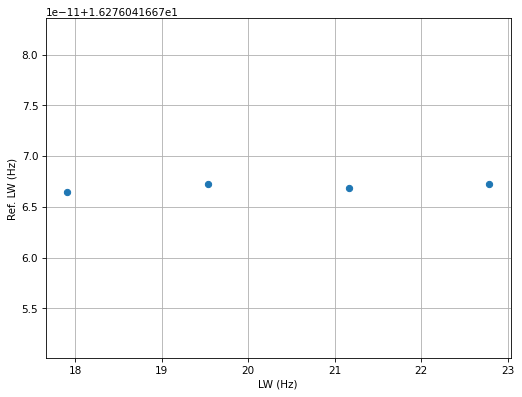

In [64]:
# extract lw from WS and noWS data
lw_list = []
lw_ref_list = []

for this_patient in rdb_sel:
    for this_study in rdb_sel[this_patient]:
        for this_scan in rdb_sel[this_patient][this_study]:
            this_lw = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["cropping"]["lw"]
            this_lw_ref = rdb_sel[this_patient][this_study][this_scan]["dataset"]["raw"]["ref-data-analysis-results"]["lw"]
            
            # store
            lw_list.append(this_lw)
            lw_ref_list.append(this_lw_ref)
            
fig = plt.figure()
ax = fig.subplots()
ax.scatter(lw_list, lw_ref_list)

ax.grid('on')
ax.set_xlabel("LW (Hz)")
ax.set_ylabel("Ref. LW (Hz)") 


## 1st vs. 2nd order shimming?
- Did 2nd order shim help? Extracting data from notebooks.

In [ ]:
patient_list = [313,     319,     328, 329, 333, 336,  338,  300,    311,  336,  319,  313,  314,  349  ]
study_list = [  1,         1,       1,   1,   1,   1,    1,    2,      2,    1,    2,    2,    2,    2  ]
lw_linear = [   45,       25,      25,  30,  45,  30,   25,   35, np.nan,  100,   39,   30,   20,   26  ]
lw_full = [     55,   np.nan,      40,  25,  50,  60,   35, 37.5,     25,   27,  100,   50,   25,   30  ]



## Compare no trig, cardiac and resp gating
For subjects where scanned in the same study using various gating methods
- compare final SNR and LW
- compare peak properties variability (before data rejection)

In [15]:
import mrs.sim as sim

# find scans identical except for gating parameter
def sel_gating_tests(dataset_entry):
    if( (dataset_entry["patient"] == 300 and dataset_entry["study"] == 1) or
        (dataset_entry["patient"] == 307 and dataset_entry["study"] == 1) or
        (dataset_entry["patient"] == 311 and dataset_entry["study"] == 2) or
        (dataset_entry["patient"] == 336 and dataset_entry["study"] == 2) )
    r = (True)
    return(r)

rdb_sel_gating_tests = rdb.select_datasets(sel_gating_tests)

# extract SNR and LW estimation regarding frequency realignment and data rejection
gating_mode_header = [sim.gating_signal_source.NO_GATING, sim.gating_signal_source.CARDIAC_ECG, sim.gating_signal_source.CARDIAC_GATING, sim.gating_signal_source.RESP_GATING]
gating_none_cardiac_resp_list = np.full([4, 4], False)

snr_precor_none_cardiac_resp_list = np.full([4, 4], None)
lw_precor_none_cardiac_resp_list = np.full([4, 4], None)
snr_postcor_none_cardiac_resp_list = np.full([4, 4], None)
lw_postcor_none_cardiac_resp_list = np.full([4, 4], None)
peak_prop_mean_list = np.full([4, 4], None)
peak_prop_std_list = np.full([4, 4], None)

k_scan = -1
for this_patient in rdb_sel:
    for this_study in rdb_sel[this_patient]:
        k_scan += 1
        for this_scan in rdb_sel[this_patient][this_study]:
            # gating mode?
            g = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["data"].sequence.gating_mode
            
            if(g == sim.gating_signal_source.NO_GATING):
                ind_gating = 0
            elif(g == sim.gating_signal_source.CARDIAC_ECG):
                ind_gating = 1
            elif(g == sim.gating_signal_source.CARDIAC_GATING):
                ind_gating = 2
            elif(g == sim.gating_signal_source.RESP_GATING):
                ind_gating = 3
                
            peak_prop = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["data"].data_rejection[0]["Pre-rejection"]["measurements"]
            amp_mean = np.mean(peak_prop[:,0])
            amp_std = np.std(peak_prop[:,0])
            lw_mean = np.mean(peak_prop[:,1])
            lw_std = np.std(peak_prop[:,1])
            f_mean = np.mean(peak_prop[:,2])
            f_std = np.std(peak_prop[:,2]) 
            ph_mean = np.mean(peak_prop[:,3])
            ph_std = np.std(peak_prop[:,3])
            
            # snr and lw before cor
            snr_before_realign = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["apodizing"]["snr"]
            lw_before_realign = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["apodizing"]["lw"]
            # snr and lw after cor
            snr_after_realign = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["frequency realigning"]["snr"]
            lw_after_realign = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["frequency realigning"]["lw"]
                        
            # store
            gating_none_cardiac_resp_list[k_scan, ind_gating] = True
            snr_precor_none_cardiac_resp_list[k_scan, ind_gating] = snr_before_realign
            lw_precor_none_cardiac_resp_list[k_scan, ind_gating] = lw_before_realign
            snr_postcor_none_cardiac_resp_list[k_scan, ind_gating] = snr_after_realign
            lw_postcor_none_cardiac_resp_list[k_scan, ind_gating] = lw_after_realign
            peak_prop_mean_list[k_scan, ind_gating] = [amp_mean, lw_mean, f_mean, ph_mean]
            peak_prop_std_list[k_scan, ind_gating] = [amp_std, lw_std, f_std, ph_std]
     
        
        
        
        
        
        
        

In [1]:
from IPython import get_ipython
import matplotlib.pylab as plt
import mrs.fit as fit
import mrs.sim as sim
import mrs.reco as reco
import mrs.aliases as xxx
import mrs.db as db
import mrs.log as log
import numpy as np

import pdb

get_ipython().magic("clear")
plt.close("all")

get_ipython().magic("matplotlib auto")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.max_open_warning'] = 1000
plt.rcParams['font.size'] = 9
log.setLevel(log.DEBUG)

rdb = db.data_db("/home/tangir/crmbm/acq_db/20201023_brain_fit_test.pkl")

import pandas as pd

# %% test

def _scrap_data(var, var_str):
    """..."""

    par_name_list = []
    par_val_list = []

    if(type(var) == dict):
        for this_dict_key in var:
            if(type(this_dict_key) is str and this_dict_key[0] != '_'):
                name_list, val_list = _scrap_data(var[this_dict_key], this_dict_key)

                par_name_list = par_name_list + name_list
                par_val_list = par_val_list + val_list

    elif(type(var) == list):
        for ind, this_item in enumerate(var):
            name_list, val_list = _scrap_data(this_item, "[" + str(ind) + "]")

            par_name_list = par_name_list + name_list
            par_val_list = par_val_list + val_list

    elif(isinstance(var, (reco.MRSData2, reco.pipeline, sim.mrs_sequence))):
        name_list, val_list = _scrap_data(var.__dict__, "")
        par_name_list = par_name_list + name_list
        par_val_list = par_val_list + val_list

    else:
        par_name_list = par_name_list + [var_str]
        par_val_list = par_val_list + [var]

    par_name_list = [str(var_str) + "_" + s for s in par_name_list]

    return(par_name_list, par_val_list)


df_list2 = []

for patient_key in rdb:
    for study_key in rdb[patient_key]:
        for hash_key in rdb[patient_key][study_key]:
            this_entry = rdb[patient_key][study_key][hash_key]
            this_column_list, this_values_list = _scrap_data(this_entry, "root")

            df = pd.DataFrame([this_values_list], columns=this_column_list)

            df_list2.append(df)


df = pd.DataFrame()
df = df.append(df_list2)
df.set_index('root_hash_hash')

(DEBUG) Loaded backend qt5agg version unknown.
(DEBUG) Loaded backend Qt5Agg version unknown.


Using matplotlib backend: Qt5Agg


(DEBUG) data_db._read_db_file: reading db file [/home/tangir/crmbm/acq_db/20201023_brain_fit_test.pkl]...


,root_patient_patient,root_study_study,root_dataset_legend_legend,root_dataset_raw_files_[0]_[0],root_dataset_raw_files_[1]_[1],root_dataset_raw_data__ppm0_ppm0,root_dataset_raw_data__transform_transform,root_dataset_raw_data__metadata_patient_name_patient_name,root_dataset_raw_data__metadata_patient_id_patient_id,root_dataset_raw_data__metadata_patient_birthdate_patient_birthdate,root_dataset_raw_data__metadata_exam_date_exam_date,root_dataset_raw_data__metadata_exam_time_exam_time,root_dataset_raw_data__voxel_dimensions_voxel_dimensions,root_dataset_raw_data__data_ref__ppm0_ppm0,root_dataset_raw_data__data_ref__transform_transform,root_dataset_raw_data__data_ref__metadata_patient_name_patient_name,root_dataset_raw_data__data_ref__metadata_patient_id_patient_id,root_dataset_raw_data__data_ref__metadata_patient_birthdate_patient_birthdate,root_dataset_raw_data__data_ref__metadata_exam_date_exam_date,root_dataset_raw_data__data_ref__metadata_exam_time_exam_time,root_dataset_raw_data__data_ref__voxel_dimensions_voxel_dimensions,root_dataset_raw_data__data_ref__data_ref_data_ref,root_dataset_raw_analysis-results_phasing_snr_snr,root_dataset_raw_analysis-results_phasing_lw_lw,root_dataset_raw_analysis-results_scaling intensity_snr_snr,root_dataset_raw_analysis-results_scaling intensity_lw_lw,root_dataset_raw_analysis-results_channel-combining_snr_snr,root_dataset_raw_analysis-results_channel-combining_lw_lw,root_dataset_raw_analysis-results_estimating noise level_snr_snr,root_dataset_raw_analysis-results_estimating noise level_lw_lw,root_dataset_raw_analysis-results_zero-filling_snr_snr,root_dataset_raw_analysis-results_zero-filling_lw_lw,root_dataset_raw_analysis-results_apodizing_snr_snr,root_dataset_raw_analysis-results_apodizing_lw_lw,root_dataset_raw_analysis-results_frequency realigning_snr_snr,root_dataset_raw_analysis-results_frequency realigning_lw_lw,root_dataset_raw_analysis-results_data rejecting_snr_snr,root_dataset_raw_analysis-results_data rejecting_lw_lw,root_dataset_raw_analysis-results_averaging_snr_snr,root_dataset_raw_analysis-results_averaging_lw_lw,...,root_reco_pipeline__analyze_job_list_[1]_display_range_ppm_[0]_[0],root_reco_pipeline__analyze_job_list_[1]_display_range_ppm_[1]_[1],root_reco_pipeline__analyze_job_list_[2]_na_na,root_reco_pipeline__analyze_job_list_[2]_display_display,root_reco_pipeline__analyze_job_list_[2]_display_range_ppm_[0]_[0],root_reco_pipeline__analyze_job_list_[2]_display_range_ppm_[1]_[1],root_reco_pipeline__analyze_job_list_[3]_POI_shift_range_ppm_[0]_[0],root_reco_pipeline__analyze_job_list_[3]_POI_shift_range_ppm_[1]_[1],root_reco_pipeline__analyze_job_list_[3]_POI_shift_true_ppm_POI_shift_true_ppm,root_reco_pipeline__analyze_job_list_[3]_display_display,root_reco_pipeline__analyze_job_list_[3]_display_range_ppm_[0]_[0],root_reco_pipeline__analyze_job_list_[3]_display_range_ppm_[1]_[1],root_reco_pipeline__analyze_enable_analyze_enable,root_reco_pipeline__analyze_display_analyze_display,root_fit_pipeline_easy_params_ref_area_params_ref_area,root_fit_pipeline_easy_params_ref_area_pnorm_params_ref_area_pnorm,root_fit_pipeline_easy_params_area_params_area,root_fit_pipeline_easy_params_area_pnorm_params_area_pnorm,root_fit_pipeline_easy_params_ref_fit_params_ref_fit,root_fit_pipeline_easy_params_fit_final_params_fit_final,root_fit_pipeline_easy_optim_result_optim_result,root_fit_pipeline_easy_fittool_fittool,root_fit_pipeline_medium_params_ref_area_params_ref_area,root_fit_pipeline_medium_params_ref_area_pnorm_params_ref_area_pnorm,root_fit_pipeline_medium_params_area_params_area,root_fit_pipeline_medium_params_area_pnorm_params_area_pnorm,root_fit_pipeline_medium_params_ref_fit_params_ref_fit,root_fit_pipeline_medium_params_fit_final_params_fit_final,root_fit_pipeline_medium_optim_result_optim_result,root_fit_pipeline_medium_fittool_fittool,root_fit_pipeline_hard_params_ref_area_params_ref_area,root_fit_pipeline_hard_params_ref_area_pnorm_params_ref_area_pnorm,root_fit_pipeline_har

In [2]:
df["root_dataset_dcm_analysis-results_channel-combining_snr_snr"]


0     73.744009
0    103.592539
0     92.495380
0     19.701756
Name: root_dataset_dcm_analysis-results_channel-combining_snr_snr, dtype: float64